## ewf-ext-02-02-01 Oil sheen of natural oil seepage with Sentinel-1

### <a name="service">Service definition

In [1]:
service = dict([('title', 'ewf-ext-02-02-01 Oil sheen of natural oil seepage with Sentinel-1'),
                ('abstract', 'ewf-ext-02-02-01 Oil sheen of natural oil seepage with Sentinel-1'),
                ('id', 'ewf-ext-02-02-01')])

### <a name="runtime">Runtime parameter definition

**Input identifiers**

This is the Sentinel-1 stack of products' identifiers

In [2]:
input_identifiers = ( 'S1B_IW_GRDH_1SDH_20171025T204653_20171025T204718_007991_00E1E2_CBD2', ) 

**Input references**

This is the Sentinel-1 stack catalogue references

In [3]:
input_references = ('https://catalog.terradue.com/sentinel1/search?uid=S1B_IW_GRDH_1SDH_20171025T204653_20171025T204718_007991_00E1E2_CBD2',) 

**Data path**

This path defines where the data is staged-in. 

In [4]:
data_path = "/workspace/data"

### <a name="workflow">Workflow

#### Import the packages required for processing the data

In [5]:
from snappy import jpy
from snappy import ProductIO

#### Read the products

In [6]:
s1meta = "manifest.safe"

products = []

for s1path in input_identifiers:

    s1prd= "%s/%s/%s.SAFE/%s" % (data_path, s1path, s1path, s1meta)
    reader = ProductIO.getProductReader("SENTINEL-1")
    product = reader.readProductNodes(s1prd, None)
    products.append(product)

#### Extract information about the Sentinel-1 GRD products:

In [7]:
for product in products:

    width = product.getSceneRasterWidth()
    height = product.getSceneRasterHeight()
    name = product.getName()
    band_names = product.getBandNames()
    print("Product: %s, %d x %d pixels" % (name, width, height))
    print("Bands:   %s" % (list(band_names)))

Product: S1B_IW_GRDH_1SDH_20171025T204653_20171025T204718_007991_00E1E2_CBD2, 25920 x 16645 pixels
Bands:   ['Amplitude_HH', 'Intensity_HH', 'Amplitude_HV', 'Intensity_HV']


#### Process the data

* Step 0: Data preparation - Subset
* Step 1: Pre-processing - Calibration
* Step 2: Pre-processing - Speckle filtering
* Step 3: Pre-processing - Linear to dB
* Step 4: Distribution analysis and probability density function fitting
* Step 5: Anomaly index 1 - Backscattering spread
* Step 6: Anomaly index 2 - Backscattering statistical distribution distance
* Step 7: Anomaly index 3 - Final score


##### <a name="subset">Step 0: Data preparation - Subset

We extract a subset of the Sentinel-1 GRD products by specify a rectangle:

In [8]:
aoi = 'POLYGON((-54.333 71.559, -49.842 71.559, -49.842 69.713, -54.333 69.713, -54.333 71.559))'

In [9]:
from snappy import GPF
from snappy import HashMap
import snappy

WKTReader = snappy.jpy.get_type('com.vividsolutions.jts.io.WKTReader')

geom = WKTReader().read(aoi);


HashMap = jpy.get_type('java.util.HashMap')    
GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

parameters = HashMap()
parameters.put('copyMetadata', True)
parameters.put('geoRegion', geom)

subsets = []

for product in products:

    subset = GPF.createProduct('Subset', parameters, product)
    subsets.append(subset)

##### <a name="calibration">Step 1: Pre-processing - Land-Sea-Mask

In [10]:
parameters = HashMap()

parameters.put('vectorFile', '/workspace/dev/ewf-ext-02-02-01/src/main/app-resources/notebook/libexec/land_vector/land.shp')
parameters.put('separateShapes', False)

addvectors = []

for subset in subsets:

    addvector = GPF.createProduct('Import-Vector', parameters, subset)
    addvectors.append(addvector)

In [11]:
parameters = HashMap()

parameters.put('landMask', False)
parameters.put('useSRTM', False)
parameters.put('geometry', 'land')
parameters.put('invertGeometry', True)
parameters.put('shorelineExtension', 10)

landMaskeds = []

for addvector in addvectors:
    landMasked = GPF.createProduct('Land-Sea-Mask', parameters, addvector)
    landMaskeds.append(landMasked)

##### <a name="calibration">Step 2: Pre-processing - Calibration

The objective of SAR calibration is to provide imagery in which the pixel values can be directly related to the radar backscatter of the scene. Though uncalibrated SAR imagery is sufficient for qualitative use, calibrated SAR images are essential to quantitative use of SAR data.

Typical SAR data processing, which produces level 1 images, does not include radiometric corrections and significant radiometric bias remains. Therefore, it is necessary to apply the radiometric correction to SAR images so that the pixel values of the SAR images truly represent the radar backscatter of the reflecting surface. The radiometric correction is also necessary for the comparison of SAR images acquired with different sensors, or acquired from the same sensor but at different times, in different modes, or processed by different processors.

In [12]:
parameters = HashMap()

parameters.put('auxFile', 'Latest Auxiliary File')
parameters.put('outputSigmaBand', True)
#parameters.put('selectedPolarisations', 'HH')

calibrates = []

for landMasked in landMaskeds:

    calibrate = GPF.createProduct('Calibration', parameters, landMasked)
    calibrates.append(calibrate)

##### <a name="speckle">Step X: Pre-processing - Speckle filtering

SAR images have inherent salt and pepper like texturing called speckles which degrade the quality of the image and make interpretation of features more difficult. Speckles are caused by random constructive and destructive interference of the de-phased but coherent return waves scattered by the elementary scatters within each resolution cell. Speckle noise reduction can be applied either by spatial filtering or multilook processing. 

In [13]:
'''
parameters = HashMap()

parameters.put('filter', 'Lee')
parameters.put('filterSizeX', 7)
parameters.put('filterSizeY', 7)
parameters.put('dampingFactor', 2)
parameters.put('edgeThreshold', 5000.0)
parameters.put('estimateENL', True)
parameters.put('enl', 1.0)

speckles = []

for calibrate in calibrates:

    speckle = GPF.createProduct('Speckle-Filter', parameters, calibrate)
    speckles.append(speckle)
'''

"\nparameters = HashMap()\n\nparameters.put('filter', 'Lee')\nparameters.put('filterSizeX', 7)\nparameters.put('filterSizeY', 7)\nparameters.put('dampingFactor', 2)\nparameters.put('edgeThreshold', 5000.0)\nparameters.put('estimateENL', True)\nparameters.put('enl', 1.0)\n\nspeckles = []\n\nfor calibrate in calibrates:\n\n    speckle = GPF.createProduct('Speckle-Filter', parameters, calibrate)\n    speckles.append(speckle)\n"

In [14]:
parameters = HashMap()

parameters.put('sourceBands', 'Sigma0_HH,Sigma0_HV')
parameters.put('backgroundWindowSize', 13)
parameters.put('k', 2.0)

speckles = []

for calibrate in calibrates:

    speckle = GPF.createProduct('Oil-Spill-Detection', parameters, calibrate)
    speckles.append(speckle)

#####  <a name="lineartodb">Step 3: Pre-processing - Linear to dB

In [15]:
'''
parameters = HashMap()

lineartodbs= []
dates = [];

for speckle in speckles : 

    lineartodb = GPF.createProduct('linearToFromdB', parameters, speckle)
    lineartodbs.append(lineartodb)
    name = lineartodb.getName()
    timestamp = name.split("_")[5] 
    date = timestamp[:8]
    dates.append(date)
'''

parameters = HashMap()

parameters.put('minClusterSizeInKm2', 0.1)

lineartodbs= []
dates = [];

for speckle in speckles : 

    lineartodb = GPF.createProduct('Oil-Spill-Clustering', parameters, speckle)
    lineartodbs.append(lineartodb)
    name = lineartodb.getName()
    timestamp = name.split("_")[5] 
    date = timestamp[:8]
    dates.append(date)

In [16]:
dir(lineartodb)

['DEFAULT_IMAGE_CRS',
 'GEOMETRY_FEATURE_TYPE_NAME',
 'HISTORY_ROOT_NAME',
 'METADATA_ROOT_NAME',
 'PROPERTY_NAME_DESCRIPTION',
 'PROPERTY_NAME_FILE_LOCATION',
 'PROPERTY_NAME_NAME',
 'PROPERTY_NAME_PRODUCT_TYPE',
 'PROPERTY_NAME_SCENE_CRS',
 'PROPERTY_NAME_SCENE_GEO_CODING',
 'PROPERTY_NAME_SCENE_TIME_CODING',
 '__class__',
 '__delattr__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__jinit__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'acceptVisitor',
 'addBand',
 'addMask',
 'addProductNodeListener',
 'addTiePointGrid',
 'canBeOrthorectified',
 'closeIO',
 'closeProductReader',
 'closeProductWriter',
 'containsBand',
 'containsPixel',
 'containsRasterDataNode',
 'containsTiePointGrid',
 'createBandArithmeticDefaultNamespace',
 'createBandArithmeticParser',
 'createMultiLevelModel',
 'createPixelInfoString',

In [17]:
band_names = list(lineartodbs[0].getBandNames())
print(band_names)

['Sigma0_HH', 'Sigma0_HH_oil_spill_bit_msk', 'Sigma0_HV', 'Sigma0_HV_oil_spill_bit_msk']


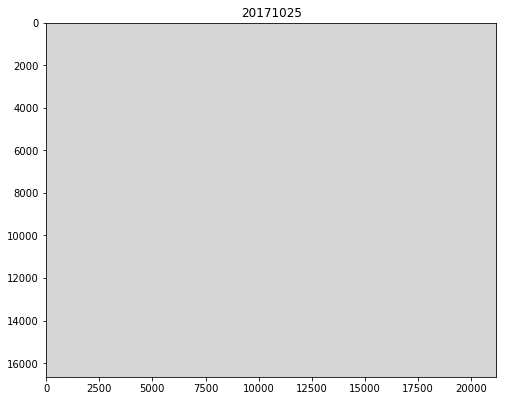

1108

In [18]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import gc 

%matplotlib inline

def plotBand(product, band, vmin, vmax):
     
    band = product.getBand(band)

    w = band.getRasterWidth()
    h = band.getRasterHeight()

    band_data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, band_data)

    band_data.shape = h, w

    imgplot = plt.imshow(band_data, cmap=plt.cm.binary_r, vmin=vmin, vmax=vmax)

    
    return imgplot 


fig = plt.figure(figsize=(20,20))
i = 1


for lineartodb in lineartodbs :
    
        a=fig.add_subplot(330+i)
        imgplot = plotBand(lineartodb, 'Sigma0_HH', -25, 5)
        name = lineartodb.getName()
        timestamp = name.split("_")[5] 
        date = timestamp[:8]
        a.set_title(date)
        i = i+1

plt.tight_layout()
fig = plt.gcf()
plt.show()

fig.clf()
plt.close()
gc.collect()

In [19]:
lineartodbs[0].getName()

'Subset_S1B_IW_GRDH_1SDH_20171025T204653_20171025T204718_007991_00E1E2_CBD2_Cal'

In [ ]:
thermal_noise_removal = None
apply_orbit_file = None
calibration = None
speckle_filter = None
terrain_correction = None

gc.collect()

In [20]:
 ProductIO.writeProduct(lineartodbs[0], lineartodbs[0].getName(), 'BEAM-DIMAP')